### Case Study

FTX allows customers to trade based on the size of Move for Bitcoin. If we can determine a model, which can forecast better than 50/50 accuracy, whether or not Bitcoins move will likely be above it's average, then we have an edge.

The catch is, how to predict whether future volatility will be above or below the rolling average (assuming that the rolling average is where the market adjusts to). Regardless, this will be a significant challenge and we will need state-of-the-art methods, whilst making sure we do not overfit.

### Imports

In [2]:
import numpy as np
import pandas as pd
from stratmanager import StrategyManager
import sklearn.mixture as mix
from ta.momentum import RSIIndicator
import matplotlib.pyplot as plt
import yfinance

### Data Extraction and Returns Overview

In [3]:
# Extract Data
start_date = "2005-01-1"
end_date = "2022-06-1"
    
symbol = "IOC.NS"
strat_mgr = StrategyManager(symbol, start_date, end_date)
df = strat_mgr.df.copy()
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets
Date,,,,,,,,
2005-01-04,20.386473,20.741363,20.386473,20.599407,6488232,0.010933,0.017408,0.015965
2005-01-05,20.701938,20.701938,19.325752,19.871889,3346896,-0.035317,0.071210,-0.017874
2005-01-06,19.913291,19.990185,19.349410,19.818653,5798196,-0.002679,0.033116,-0.029470
2005-01-07,19.637258,19.794986,19.459812,19.597824,3811332,-0.011142,0.017224,-0.017112
2005-01-10,20.071019,20.071019,19.207454,19.282375,2053332,-0.016096,0.044960,-0.028977


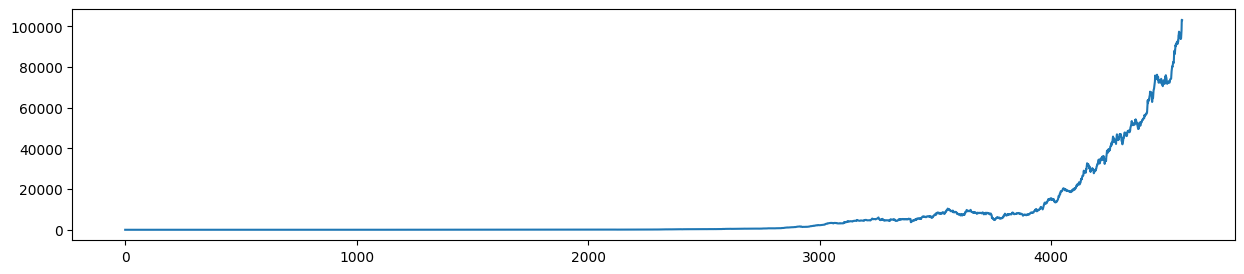

In [4]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 3))
plt.plot(df["Bench_C_Rets"].values)
plt.show()

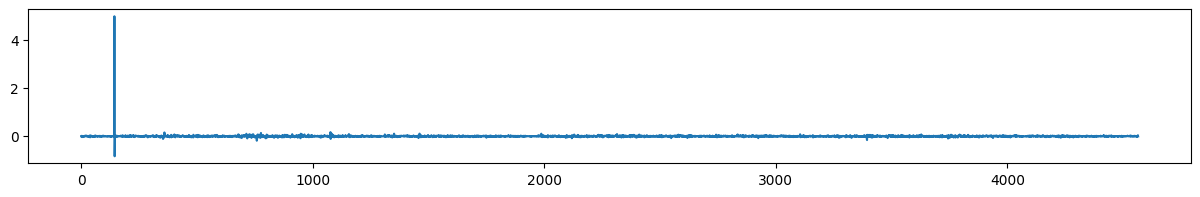

In [5]:
# Benchmark Returns Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Returns"].values)
plt.show()

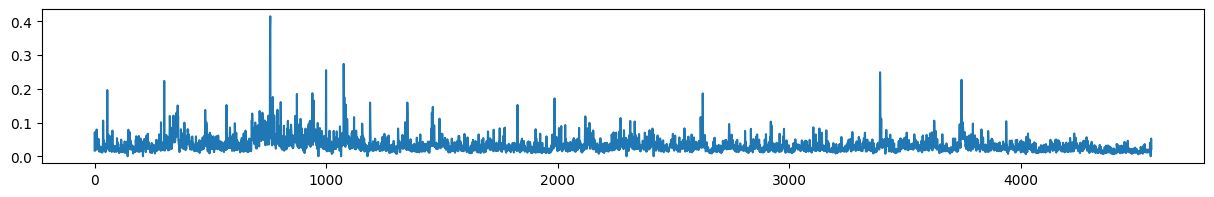

In [6]:
# Benchmark Range Profile
fig = plt.figure(figsize = (15, 2))
plt.plot(df["Range"].values)
plt.show()

### Feature Engineering - Feature Expansion

In [7]:
# Create a copy
df_fe = df.copy()

##### Indicators

In [8]:
# Add RSI
rsi = RSIIndicator(close=df_fe["Close"], window=14).rsi()
df_fe["RSI"] = rsi
df_fe["RSI_Ret"] = df_fe["RSI"] / df_fe["RSI"].shift(1)

In [9]:
# Add Moving Average
df_fe["MA_12"] = df_fe["Close"].rolling(window=12).mean()
df_fe["MA_21"] = df_fe["Close"].rolling(window=21).mean()

In [10]:
# Day of Week
df_fe["DOW"] = df_fe.index.dayofweek

In [11]:
# Rolling Cumulative Returns
df_fe["Roll_Rets"] = df_fe["Returns"].rolling(window=30).sum()

In [12]:
# Rolling Cumulative Range
df_fe["Avg_Range"] = df_fe["Range"].rolling(window=30).mean()

##### Time Intervals

In [13]:
# Add Time Intervals
t_steps = [1, 2]
t_features = ["Returns", "Range", "RSI_Ret"]
for ts in t_steps:
    for tf in t_features:
        df_fe[f"{tf}_T{ts}"] = df_fe[tf].shift(ts)

In [13]:
# Show DataFrame
df_fe.tail(3)

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-29,573.099976,573.099976,573.099976,573.099976,0,0.000000,0.000000,119559.972775,62.812262,1.00000,...,561.809524,3,0.108890,0.020089,0.009245,0.014865,1.036891,0.014652,0.020079,1.066252
2023-06-30,588.349976,599.000000,588.000000,595.549988,12488047,0.039173,0.018707,125171.896041,70.972834,1.12992,...,565.107143,4,0.161739,0.019806,0.000000,0.000000,1.000000,0.009245,0.014865,1.036891
2023-07-03,600.000000,602.299988,590.000000,590.799988,11131048,-0.007976,0.020847,124930.196352,67.593082,0.95238,...,567.754761,0,0.121312,0.019071,0.039173,0.018707,1.129920,0.000000,0.000000,1.000000


### Feature Engineering - Feature Scaling

In [14]:
# Correct for Stationarity
df_fs = df_fe.copy()
df_fs[["Open", "High", "Low", "Volume"]] = df_fs[["Open", "High", "Low", "Volume"]].pct_change()
df_fs

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,NaN,NaN,NaN,83.520256,NaN,-0.001249,0.015348,-0.007590,NaN,NaN,...,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,-0.013466,-0.012549,-0.073359,80.933350,1.168458,-0.030973,0.081979,-0.043483,NaN,NaN,...,NaN,2,NaN,NaN,-0.001249,0.015348,NaN,NaN,NaN,NaN
2005-01-06,-0.030010,-0.019159,0.019167,79.246239,-0.216910,-0.020846,0.041292,-0.073107,NaN,NaN,...,NaN,3,NaN,NaN,-0.030973,0.081979,NaN,-0.001249,0.015348,NaN
2005-01-07,-0.025748,-0.022379,-0.005724,79.173935,-0.356559,-0.000912,0.023849,-0.066341,NaN,NaN,...,NaN,4,NaN,NaN,-0.020846,0.041292,NaN,-0.030973,0.081979,NaN
2005-01-10,0.017824,-0.002410,-0.053762,76.321899,-0.152630,-0.036022,0.079413,-0.090500,NaN,NaN,...,NaN,0,NaN,NaN,-0.000912,0.023849,NaN,-0.020846,0.041292,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-26,-0.017544,-0.003764,0.000179,567.849976,-0.253781,0.014652,0.020079,115394.085049,60.577488,1.066252,...,556.764288,0,0.070531,0.021437,-0.017037,0.024117,0.895123,-0.020726,0.029039,0.864846
2023-06-27,0.017857,0.013884,0.019093,573.099976,0.346066,0.009245,0.014865,116460.958735,62.812262,1.036891,...,559.223810,1,0.098049,0.020834,0.014652,0.020079,1.066252,-0.017037,0.024117,0.895123
2023-06-29,0.005439,-0.006587,0.008180,573.099976,-1.000000,0.000000,0.000000,119559.972775,62.812262,1.000000,...,561.809524,3,0.108890,0.020089,0.009245,0.014865,1.036891,0.014652,0.020079,1.066252


### Assess Data for ML Readiness

In [15]:
# Check for NaN
df_fs.dropna(inplace=True)
print(df_fs.isnull().values.any())

False


In [16]:
# Check for Inf values
dfobj = df_fs.isin([np.inf, -np.inf])
count = np.isinf(dfobj).values.sum()
count

0

In [17]:
# Check for non-numerical objects
df_fs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4536 entries, 2005-02-16 to 2023-07-03
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          4536 non-null   float64
 1   High          4536 non-null   float64
 2   Low           4536 non-null   float64
 3   Close         4536 non-null   float64
 4   Volume        4536 non-null   float64
 5   Returns       4536 non-null   float64
 6   Range         4536 non-null   float64
 7   Bench_C_Rets  4536 non-null   float64
 8   RSI           4536 non-null   float64
 9   RSI_Ret       4536 non-null   float64
 10  MA_12         4536 non-null   float64
 11  MA_21         4536 non-null   float64
 12  DOW           4536 non-null   int32  
 13  Roll_Rets     4536 non-null   float64
 14  Avg_Range     4536 non-null   float64
 15  Returns_T1    4536 non-null   float64
 16  Range_T1      4536 non-null   float64
 17  RSI_Ret_T1    4536 non-null   float64
 18  Returns_T2

In [18]:
# Describe DataFrame
df_fs.describe()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,...,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
count,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,...,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000,4536.000000
mean,0.000861,0.000759,0.000860,260.971978,inf,0.000823,0.037374,6710.470285,51.264679,1.004786,...,259.881935,1.993827,0.024517,0.037398,0.000825,0.037374,1.004794,0.000818,0.037374,1.004775
std,0.029049,0.025374,0.028908,149.443659,NaN,0.027869,0.025571,17223.522723,12.858802,0.099398,...,148.402286,1.413576,0.181750,0.014644,0.027869,0.025571,0.099395,0.027863,0.025571,0.099379
min,-0.167788,-0.184751,-0.278927,23.051958,-1.000000,-0.175827,0.000000,0.050947,9.558073,0.513816,...,25.185191,0.000000,-1.047074,0.018395,-0.175827,0.000000,0.513816,-0.175827,0.000000,0.513816
25%,-0.014617,-0.011979,-0.012050,131.248001,-0.264067,-0.013858,0.022405,48.646244,42.332652,0.943715,...,130.605810,1.000000,-0.072704,0.027747,-0.013858,0.022405,0.943715,-0.013858,0.022405,0.943715
50%,0.000000,-0.000460,0.001555,230.904221,-0.025490,0.000300,0.030931,698.585882,51.204874,1.001052,...,229.405797,2.000000,0.025389,0.033565,0.000300,0.030931,1.001052,0.000300,0.030931,1.001052
75%,0.015320,0.012131,0.014132,399.137505,0.322396,0.014652,0.044307,2502.810885,60.893476,1.053994,...,400.911191,3.000000,0.118516,0.042349,0.014652,0.044307,1.053994,0.014630,0.044307,1.053867
max,0.184847,0.202318,0.251701,597.892273,inf,0.204467,0.356489,125171.896041,91.791621,1.923258,...,572.225691,6.000000,0.809081,0.126170,0.204467,0.356489,1.923258,0.204467,0.356489,1.923258


### Save Data

In [19]:
# Save DataFrame
df_fs.to_csv(f"data/{symbol}.csv")